# Báo Cáo cuối kỳ môn FDC 104
## Đề tài: Phân tích các yếu tố ảnh hưởng lên doanh số của Supermarket X bằng mô hình chuỗi thời gian
#### Nhóm thực hiện: Nhóm 7 
#### Thành viên:
Lê Đức Hạnh (Trưởng nhóm) <br>
Trương Thị Hạnh <br>
Lê Thị Phương Anh <br>
Nguyễn Vân Nhi <br>
Phạm Bá Lộc <br>

## Phần 1: Nhập dữ liệu và thư viện

In [3]:
!pip install pmdarima

In [3]:
# Các thư viện được sử dụng trong báo cáo này

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox, normal_ad

from pmdarima import auto_arima

ModuleNotFoundError: No module named 'pmdarima'

In [5]:
%matplotlib inline

In [5]:
# Nhập dữ liệu
path = 'https://raw.githubusercontent.com/trangmx/fdc104/main/datasets/supemakert_x/Supmarket_X.csv'
df = pd.read_csv(path)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### 1. Thông tin chung về các thuộc tính
    1. Store - the store number
    2. Date - the week of sales
    3. Weekly_Sales - sales for the given store
    4. Holiday_Flag - whether the week is a special holiday week (1 – Holiday week, 0 – Non-holiday week)
    5. Temperature - Temperature on the day of sale
    6. Fuel_Price - Cost of fuel in the region
    7. CPI – Prevailing consumer price index
    8. Unemployment - Prevailing unemployment rate

### 2. Tổng quan về dữ liệu

In [9]:
# Tổng quan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


<b> >> Date đang bị format sai

In [11]:
# Giá trị Unique của mỗi thuộc tính
df.nunique()

Store             45
Date             143
Weekly_Sales    6435
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
dtype: int64

<b> >> Có tổng cộng 45 cửa hàng <br>
<b> >> Dữ liệu doanh số được ghi nhận trong 143 tuần <br>

In [13]:
# Kiểm tra dữ liệu trống
df.isnull().sum(axis = 0)

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

<b>Kết luận: </b> Bộ dữ liệu không có dữ liệu trống

## Phần 2: Data Preprocessing and Cleansing

<b> Correcting data format

In [6]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


<b>Đưa dữ liệu Weekly_Sales và CPI về dạng logarit tự nhiên

In [7]:
df['Weekly_Sales'] = np.log(df['Weekly_Sales'] + 1e-9)
df['CPI'] = np.log(df['CPI'] + 1e-9)
df = df.rename(columns={
    'Weekly_Sales': 'Log_Weekly_Sales',
    'CPI': 'Log_CPI'
})
df.head(6)

,Store,Date,Log_Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,Log_CPI,Unemployment
0,1,2010-02-05,14.312455,0,42.31,2.572,5.352315,8.106
1,1,2010-02-12,14.311400,1,38.51,2.548,5.353005,8.106
2,1,2010-02-19,14.292966,0,39.93,2.514,5.353228,8.106
3,1,2010-02-26,14.158907,0,46.63,2.561,5.353372,8.106
4,1,2010-03-05,14.256862,0,46.50,2.625,5.353516,8.106
5,1,2010-03-12,14.179835,0,57.79,2.667,5.353661,8.106


<b> Thông tin về ngày lễ </b>

In [8]:
SuperBowl = ['12-02-2010', '11-02-2011', '10-02-2012', '08-02-2013']
LabourDay = ['10-09-2010', '09-09-2011', '07-09-2012', '06-09-2013']
Thanksgiving = ['26-11-2010', '25-11-2011', '23-11-2012', '29-11-2013']
Christmas = ['31-12-2010', '30-12-2011', '28-12-2012', '27-12-2013']

holidays = {
    'Super Bowl' : SuperBowl,
    'Labour Day' : LabourDay,
    'Thanksgiving' : Thanksgiving,
    'Christmas' : Christmas
}
holidays_df = pd.DataFrame(holidays)
holidays_df

,Super Bowl,Labour Day,Thanksgiving,Christmas
0,12-02-2010,10-09-2010,26-11-2010,31-12-2010
1,11-02-2011,09-09-2011,25-11-2011,30-12-2011
2,10-02-2012,07-09-2012,23-11-2012,28-12-2012
3,08-02-2013,06-09-2013,29-11-2013,27-12-2013


In [9]:
# Convert the dates to datetime format
SuperBowl = pd.to_datetime(SuperBowl, format='%d-%m-%Y')
LabourDay = pd.to_datetime(LabourDay, format='%d-%m-%Y')
Thanksgiving = pd.to_datetime(Thanksgiving, format='%d-%m-%Y')
Christmas = pd.to_datetime(Christmas, format='%d-%m-%Y')

# Create binary columns
df['SuperBowl'] = df['Date'].isin(SuperBowl).astype(int)
df['LabourDay'] = df['Date'].isin(LabourDay).astype(int)
df['Thanksgiving'] = df['Date'].isin(Thanksgiving).astype(int)
df['Christmas'] = df['Date'].isin(Christmas).astype(int)
df

,Store,Date,Log_Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,Log_CPI,Unemployment,SuperBowl,LabourDay,Thanksgiving,Christmas
0,1,2010-02-05,14.312455,0,42.31,2.572,5.352315,8.106,0,0,0,0
1,1,2010-02-12,14.311400,1,38.51,2.548,5.353005,8.106,1,0,0,0
2,1,2010-02-19,14.292966,0,39.93,2.514,5.353228,8.106,0,0,0,0
3,1,2010-02-26,14.158907,0,46.63,2.561,5.353372,8.106,0,0,0,0
4,1,2010-03-05,14.256862,0,46.50,2.625,5.353516,8.106,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,13.477481,0,64.88,3.997,5.257566,8.684,0,0,0,0
6431,45,2012-10-05,13.505522,0,64.89,3.985,5.258383,8.667,0,0,0,0
6432,45,2012-10-12,13.506897,0,54.47,4.000,5.259198,8.667,0,0,0,0
6433,45,2012-10-19,13.484400,0,56.47,3.969,5.259217,8.667,0,0,0,0


## Phần 3: Data Analysis

Trong báo cáo này, nhóm sẽ phân tích mức độ tác động của các yếu tố có trong bảng dữ liệu lên doanh số của Supermarket X, trong đó: <br>
    - Các biến <b> Temperature </b>, <b> Fuel_Price </b>, <b> CPI </b>, <b> Unemployment </b>, <b> SuperBowl </b>, <b> LabourDay </b>, <b> Thanksgiving </b>, <b> Christmas </b> là các biến độc lập <br>
    - Biến <b> Weekly_Sales </b> là biến phụ thuộc <br>
    <br>
    Vì các quan sát trong bảng dữ liệu được tổ chức theo chuỗi thời gian, đồng thời mô hình cần xem xét mức độ ảnh hưởng của nhiều biến ngoại sinh, nhóm quyết định sử dụng model <b>SARIMAX</b> để nghiên cứu. Đồng thời, có nhiều biến quan trọng có ảnh hưởng lớn đến doanh số (đơn cử như Quy mô cửa hàng) bị bỏ qua trong mô hình (vì không có dữ liệu). Ngoài ra, các biến khác nhau sẽ có chiều hướng tác động khác nhau lên từng cửa hàng khác nhau, vì 2 lý do trên nên bài báo cáo này sẽ nghiên cứu riêng lẻ theo từng cửa hàng. Điều này phù hợp với mô hình chuỗi thời gian mà nhóm áp dụng.

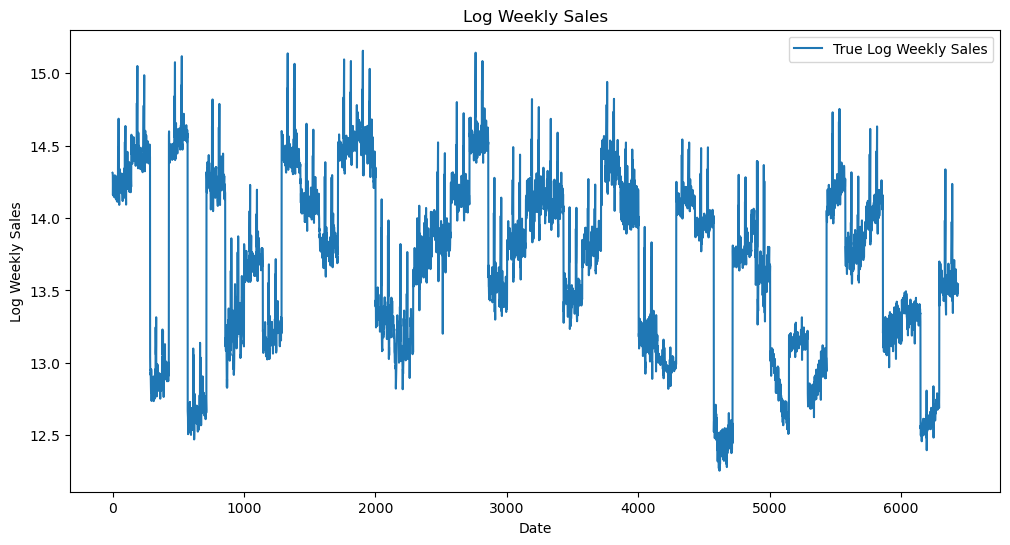

In [259]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Log_Weekly_Sales'], label='True Log Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Log Weekly Sales')
plt.title('Log Weekly Sales')
plt.legend()
plt.show()

Có nhiều cửa hàng có thay đổi lớn về doanh thu trong tuần có ngày lễ, nhưng cũng có cửa hàng không có thay đổi.

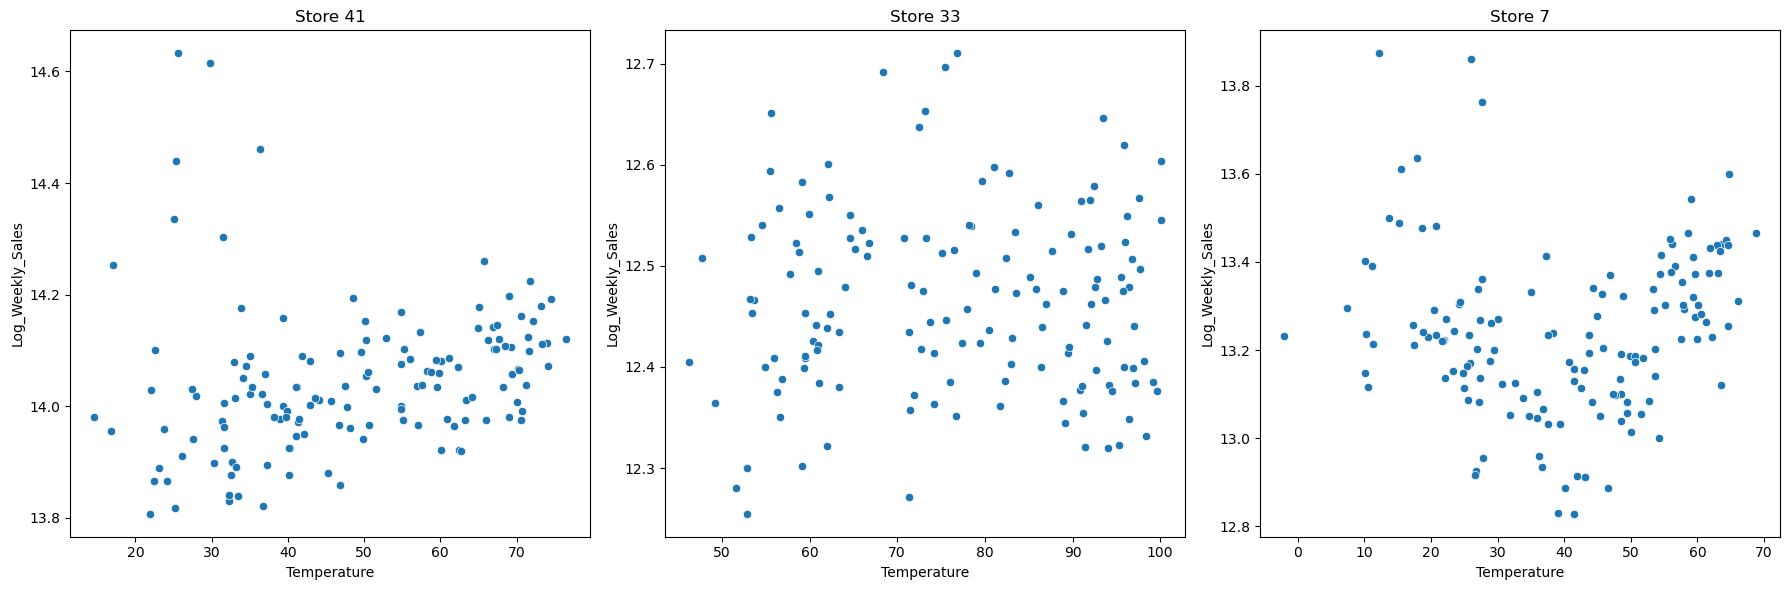

In [371]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

df41 = df[df['Store'] == 41]
sns.scatterplot(x="Temperature", y="Log_Weekly_Sales", data=df41, ax=axes[0])
axes[0].set_title("Store 41")

df33 = df[df['Store'] == 33]
sns.scatterplot(x="Temperature", y="Log_Weekly_Sales", data=df33, ax=axes[1])
axes[1].set_title("Store 33")

df7 = df[df['Store'] == 7]
sns.scatterplot(x="Temperature", y="Log_Weekly_Sales", data=df7, ax=axes[2])
axes[2].set_title("Store 7")

plt.tight_layout()
plt.show()

Cùng một biến độc lập Temperature nhưng lại có tác động khác nhau đối với từng cửa hàng

In [25]:
# Tách riêng lẻ cửa hàng
dfn = df[df['Store'] == 1]
dfn.drop(['Store'], axis =1).set_index(['Date'])

,Log_Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,Log_CPI,Unemployment,SuperBowl,LabourDay,Thanksgiving,Christmas
Date,,,,,,,,,,
2010-02-05,14.312455,0,42.31,2.572,5.352315,8.106,0,0,0,0
2010-02-12,14.311400,1,38.51,2.548,5.353005,8.106,1,0,0,0
2010-02-19,14.292966,0,39.93,2.514,5.353228,8.106,0,0,0,0
2010-02-26,14.158907,0,46.63,2.561,5.353372,8.106,0,0,0,0
2010-03-05,14.256862,0,46.50,2.625,5.353516,8.106,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2012-09-28,14.178109,0,76.08,3.666,5.407090,6.908,0,0,0,0
2012-10-05,14.328805,0,68.55,3.617,5.407985,6.573,0,0,0,0
2012-10-12,14.268541,0,62.99,3.601,5.408880,6.573,0,0,0,0


### 1. Phân tích hệ số tương quan

In [27]:
dfnc = dfn.drop(['Date', 'Store'], axis = 1, inplace = False)
dfnc.corr()

,Log_Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,Log_CPI,Unemployment,SuperBowl,LabourDay,Thanksgiving,Christmas
Log_Weekly_Sales,1.000000,0.196394,-0.210771,0.148028,0.249978,-0.120478,0.144848,0.020553,0.326371,-0.101716
Holiday_Flag,0.196394,1.000000,-0.200543,-0.085903,-0.028732,0.082949,0.533854,0.533854,0.434341,0.434341
Temperature,-0.210771,-0.200543,1.000000,0.228493,0.118637,-0.180695,-0.281764,0.115899,-0.050126,-0.182974
Fuel_Price,0.148028,-0.085903,0.228493,1.000000,0.757920,-0.513944,-0.077934,0.020844,-0.065504,-0.051380
Log_CPI,0.249978,-0.028732,0.118637,0.757920,1.000000,-0.810331,-0.039860,0.020227,-0.024058,-0.014378
Unemployment,-0.120478,0.082949,-0.180695,-0.513944,-0.810331,1.000000,0.046541,-0.022235,0.075239,0.075239
SuperBowl,0.144848,0.533854,-0.281764,-0.077934,-0.039860,0.046541,1.000000,-0.021429,-0.017434,-0.017434
LabourDay,0.020553,0.533854,0.115899,0.020844,0.020227,-0.022235,-0.021429,1.000000,-0.017434,-0.017434
Thanksgiving,0.326371,0.434341,-0.050126,-0.065504,-0.024058,0.075239,-0.017434,-0.017434,1.000000,-0.014184
Christmas,-0.101716,0.434341,-0.182974,-0.051380,-0.014378,0.075239,-0.017434,-0.017434,-0.014184,1.000000


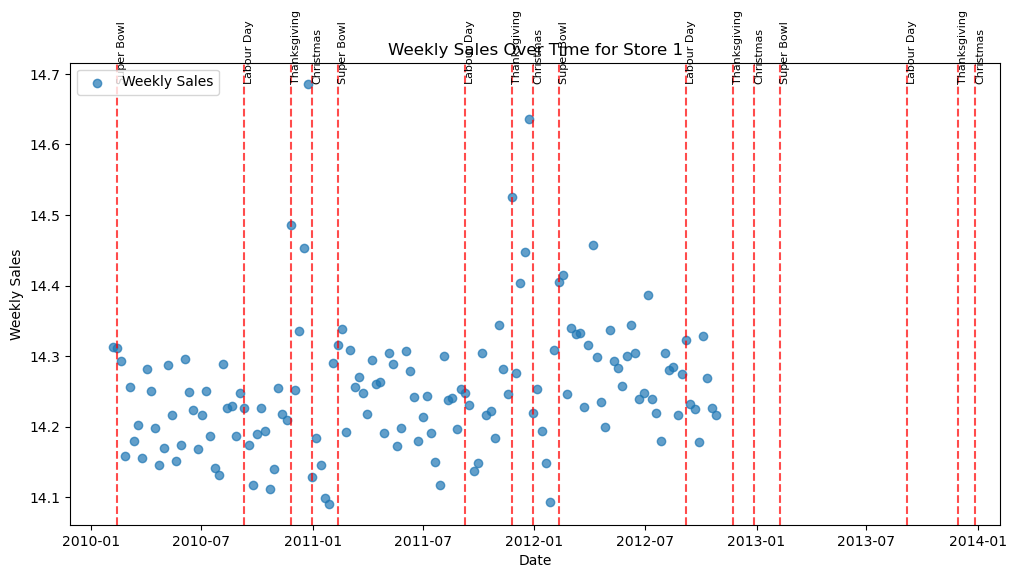

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(dfn['Date'], dfn['Log_Weekly_Sales'], alpha=0.7, label='Weekly Sales')

for holiday, dates in holidays.items():
    for date in dates:
        date = pd.to_datetime(date, format='%d-%m-%Y')
        plt.axvline(x=date, color='r', linestyle='--', alpha=0.7)
        plt.text(date, dfn['Log_Weekly_Sales'].max(), holiday, rotation=90, verticalalignment='bottom', fontsize=8)

plt.title('Weekly Sales Over Time for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

<b>Chú ý:</b> Doanh số sẽ tăng đột biến vào tuần liền trước tuần lễ Christmas thay vì vào đúng tuần lễ Christmas. Nhóm sẽ đưa các tuần lễ liền trước Christmas vào mô hình để nghiên cứu <br>


In [31]:
Christmas_1 = ['24-12-2010', '23-12-2011', '21-12-2012', '20-12-2013']

holidays = {
    'Super Bowl' : SuperBowl,
    'Labour Day' : LabourDay,
    'Thanksgiving' : Thanksgiving,
    'Christmas_1' : Christmas_1
}
holidays_df = pd.DataFrame(holidays)
holidays_df

,Super Bowl,Labour Day,Thanksgiving,Christmas_1
0,2010-02-12,2010-09-10,2010-11-26,24-12-2010
1,2011-02-11,2011-09-09,2011-11-25,23-12-2011
2,2012-02-10,2012-09-07,2012-11-23,21-12-2012
3,2013-02-08,2013-09-06,2013-11-29,20-12-2013


In [32]:
Christmas = pd.to_datetime(Christmas, format='%d-%m-%Y')
dfn['Christmas_1'] = dfn['Date'].isin(Christmas_1).astype(int)
dfn = dfn.drop(columns=['Christmas'])
dfn.drop(['Store'], axis =1, inplace = True)

/var/folders/tp/z1m25r8168qg8vk39d2chfjh0000gn/T/ipykernel_54963/3046911731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Christmas_1'] = dfn['Date'].isin(Christmas_1).astype(int)


In [384]:
dfn.head()

,Date,Log_Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,Log_CPI,Unemployment,SuperBowl,LabourDay,Thanksgiving,Christmas_1
0,2010-02-05,14.312455,0,42.31,2.572,5.352315,8.106,0,0,0,0
1,2010-02-12,14.311400,1,38.51,2.548,5.353005,8.106,1,0,0,0
2,2010-02-19,14.292966,0,39.93,2.514,5.353228,8.106,0,0,0,0
3,2010-02-26,14.158907,0,46.63,2.561,5.353372,8.106,0,0,0,0
4,2010-03-05,14.256862,0,46.50,2.625,5.353516,8.106,0,0,0,0


In [34]:
dfn.drop(['Date'], axis=1).corr()

,Log_Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,Log_CPI,Unemployment,SuperBowl,LabourDay,Thanksgiving,Christmas_1
Log_Weekly_Sales,1.000000,0.196394,-0.210771,0.148028,0.249978,-0.120478,0.144848,0.020553,0.326371,0.526252
Holiday_Flag,0.196394,1.000000,-0.200543,-0.085903,-0.028732,0.082949,0.533854,0.533854,0.434341,-0.032657
Temperature,-0.210771,-0.200543,1.000000,0.228493,0.118637,-0.180695,-0.281764,0.115899,-0.050126,-0.152320
Fuel_Price,0.148028,-0.085903,0.228493,1.000000,0.757920,-0.513944,-0.077934,0.020844,-0.065504,-0.061728
Log_CPI,0.249978,-0.028732,0.118637,0.757920,1.000000,-0.810331,-0.039860,0.020227,-0.024058,-0.016792
Unemployment,-0.120478,0.082949,-0.180695,-0.513944,-0.810331,1.000000,0.046541,-0.022235,0.075239,0.075239
SuperBowl,0.144848,0.533854,-0.281764,-0.077934,-0.039860,0.046541,1.000000,-0.021429,-0.017434,-0.017434
LabourDay,0.020553,0.533854,0.115899,0.020844,0.020227,-0.022235,-0.021429,1.000000,-0.017434,-0.017434
Thanksgiving,0.326371,0.434341,-0.050126,-0.065504,-0.024058,0.075239,-0.017434,-0.017434,1.000000,-0.014184
Christmas_1,0.526252,-0.032657,-0.152320,-0.061728,-0.016792,0.075239,-0.017434,-0.017434,-0.014184,1.000000


<b> Modified hypotheses: </b> <br>
    <b>H1:</b> Biến <b> Temperature </b>có tác động <b>âm</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H2:</b> Biến <b> Log_Fuel_Price </b>có tác động <b>dương</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H3:</b> Biến <b> Log_CPI </b>có tác động <b>dương</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H4:</b> Biến <b> Unemployment </b>có tác động <b>âm</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H5:</b> Biến <b> SuperBowl </b>có tác động <b>dương</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H6:</b> Biến <b> LabourDay </b>có tác động <b>dương</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H7:</b> Biến <b> Thanksgiving </b>có tác động <b>dương</b> lên biến <b> Log_Weekly_Sales </b> <br>
    <b>H8:</b> Biến <b> Christmas_1 </b>có tác động <b>dương</b> lên biến <b> Log_Weekly_Sales </b> <br>

### 2. ARIMA analysis

#### Chia dữ liệu
Nhóm sẽ chia dữ liệu từ trước tháng 7 năm 2020 thành tập train, dữ liệu từ sau tháng 7 sẽ trở thành tập test.

In [38]:
dfn_train = dfn[dfn['Date'] < '2012-07-01']
dfn_test = dfn[dfn['Date'] >= '2012-07-01']

Để đánh giá mức độ hiệu quả của mô hình ARIMA, thường sẽ sử dụng chỉ số AIC. Chỉ số AIC càng nhỏ thì mô hình càng có ý nghĩa. Tương tự Model fining, phương pháp Auto Arima tích hợp fit model và model tuning, cho phép chúng ta chỉ cần truyền vào giới hạn của các tham số và nó sẽ tự động tìm ra mô hình có hiệu quả tốt nhất.

In [88]:
y_train = dfn_train['Log_Weekly_Sales']
X_train = dfn_train[['Christmas_1', 'LabourDay', 'SuperBowl', 
                     'Thanksgiving', 'Log_CPI', 'Unemployment', 
                     'Fuel_Price', 'Temperature']]

model_sarima = auto_arima(y_train, X=X_train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=52,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

print(model_sarima.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=-204.512, Time=30.06 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=-205.457, Time=8.88 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=-213.468, Time=43.41 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=37.26 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=-214.267, Time=3.08 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=-213.467, Time=18.44 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=-211.467, Time=23.26 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=-225.279, Time=3.02 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=-225.039, Time=46.58 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=-224.990, Time=45.20 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=-223.048, Time=50.56 sec
 ARIMA(3,1,0)(0,1,0)[52]             : AIC=-232.042, Time=2.97 sec
 ARIMA(3,1,0)(1,1,0)[52]             : AIC=-233.449, Time=32.39 sec
 ARIMA(3,1,0)(2,1,0)[52]             : AIC=-231.465, Time=91.49 sec
 ARIMA(3,1,0)(

In [89]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                 132.257
Date:                             Fri, 14 Jun 2024   AIC                           -242.513
Time:                                     02:27:02   BIC                           -217.318
Sample:                                          0   HQIC                          -232.473
                                             - 126                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Christmas_1   1.696e-08   1.08e-14   1.57e+06      0.000     1.7e-08     1.7e-08
LabourDay     1.652e-09   1.67e-13   9911.499      0.000    1.65e-09    1.65e-09
SuperBowl     2.706e-08        nan        nan        nan         nan         nan
Thanksgiving  6.127e-09   1.16e-14   5.27e+05      0.000    6.13e-09    6.13e-09
Log_CPI          1.9829      0.801      2.475      0.013       0.413       3.553
Unemployment    -0.0638      0.033     -1.908      0.056      -0.129       0.002
Fuel_Price       0.0303      0.024      1.286      0.198      -0.016       0.077
Temperature      0.0009      0.001      1.252      0.211      -0.001       0.002
ar.L1            0.0590      0.148      0.398      0.691      -0.231       0.349
ma.L1           -0.9846      0.202     -4.872      0.000      -1.381      -0.588
sigma2           0.0015      0.000      4.061      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.90   Prob(JB):                         0.85
Heteroskedasticity (H):               1.90   Skew:                             0.05
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.77e+29. Standard errors may be unstable.
"""

In [177]:
# Predict
y_test = dfn_test['Log_Weekly_Sales']
X_test = dfn_test[['Christmas_1', 'LabourDay', 'SuperBowl', 'Thanksgiving', 'Log_CPI', 'Unemployment', 'Fuel_Price', 'Temperature']]

n_pred_periods = 17

fitted, confint = model_sarima.predict(n_periods=n_pred_periods, X=X_test[:], return_conf_int=True)
fitted_list = fitted.tolist()
print(fitted_list)

[14.31430258792679, 14.253622059510846, 14.217211033077056, 14.187230133954959, 14.369140344232127, 14.309192873939136, 14.318433447405297, 14.272676399113948, 14.332931546662877, 14.343322080347649, 14.314410763665764, 14.221340991194248, 14.234341530833145, 14.408092979773553, 14.311681344980368, 14.325690785080253, 14.280760650515862]


In [387]:
last_train_date = pd.to_datetime('2012-06-29')
data_range = pd.date_range(start=last_train_date, periods=len(fitted) + 1, freq='W')[1:]

fitted_series = pd.Series(data=fitted_list, index=data_range)

lower = confint[:, 0]
upper = confint[:, 1]

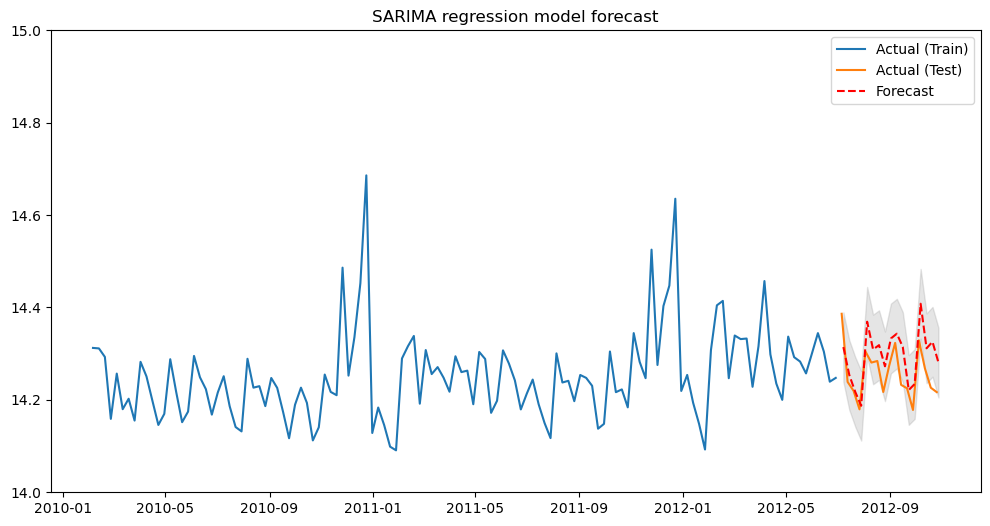

In [181]:
# Plot the actual values and forecast
plt.figure(figsize=(12, 6))
plt.plot(dfn_train['Date'], dfn_train['Log_Weekly_Sales'], label='Actual (Train)')
plt.plot(dfn_test['Date'], dfn_test['Log_Weekly_Sales'], label='Actual (Test)')
plt.plot(fitted_series, color='red', linestyle='--', label='Forecast')
plt.fill_between(date_range, lower, upper, color='grey', alpha=0.2)
plt.ylim((14, 15))
plt.legend()
plt.title('SARIMA regression model forecast')
plt.show()

### 3. Kiểm định mô hình trên tập test

In [197]:
def _measure_metric(y_test, y_hat):
  e = y_test - y_hat
  mse = np.mean(e**2)
  rmse = np.sqrt(mse)
  mae = np.mean(np.abs(e))
  mape = np.mean(e/y_test)

  print('Mean Square Error: {}'.format(mse))
  print('Root Mean Square Error: {}'.format(rmse))
  print('Mean Absolute Error: {}'.format(mae))
  print('Mean Absolute Percentage Error: {}'.format(mape))
    
  return mse, rmse, mae, mape

mse, rmse, mae, mape=_measure_metric(y_test, fitted)

Mean Square Error: 0.0029728314308438536
Root Mean Square Error: 0.05452367770834845
Mean Absolute Error: 0.046228651678658854
Mean Absolute Percentage Error: -0.002600303104398742
